In [1]:
# suppress war
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf

### Import necessary libraries

In [3]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.4 MB/s eta 0:00:00


In [4]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from typing import Tuple

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
X_train = pd.read_csv('/content/drive/MyDrive/x_train_all.csv')
X_test = pd.read_csv('/content/drive/MyDrive/x_test_all.csv')
y_train = pd.read_csv('/content/drive/MyDrive/y_train_all.csv')
y_test = pd.read_csv('/content/drive/MyDrive/y_test_all.csv')

In [7]:
 # renaming the column name in y_train from '0' to 'label'
y_train.rename(columns={'0':'label'}, inplace=True)
y_test.rename(columns={'0':'label'}, inplace=True)

---

## Pre-processing

In [8]:
# Normalize the data with min-max scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
Y_train = tf.keras.utils.to_categorical(y_train, 10)
Y_test = tf.keras.utils.to_categorical(y_test, 10)

In [10]:
from sklearn.utils import shuffle
X, Y = shuffle(X_train_scaled, Y_train)

In [11]:
# reshaping each row of data (2304) to 48x48 array for CNN input
X_reshaped = X.reshape((-1, 48, 48, 1))
X_test_reshaped = X_test_scaled.reshape((-1, 48, 48, 1))

---

# CNN

In [11]:
# training CNN model, which takes input as 48x48 array

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(48, 48, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 128)               8

In [ ]:
history = model.fit(X_reshaped,Y, epochs=50, batch_size=32, validation_data=(X_test_reshaped, Y_test))

Epoch 1/50
303/303 [==============================] - 13s 9ms/step - loss: 0.8064 - accuracy: 0.7122 - val_loss: 0.2333 - val_accuracy: 0.9301
Epoch 2/50
303/303 [==============================] - 2s 7ms/step - loss: 0.1262 - accuracy: 0.9653 - val_loss: 0.2006 - val_accuracy: 0.9440
Epoch 3/50
303/303 [==============================] - 2s 7ms/step - loss: 0.0679 - accuracy: 0.9815 - val_loss: 0.3228 - val_accuracy: 0.8958
Epoch 4/50
303/303 [==============================] - 2s 6ms/step - loss: 0.0513 - accuracy: 0.9854 - val_loss: 0.2038 - val_accuracy: 0.9463
Epoch 5/50
303/303 [==============================] - 2s 6ms/step - loss: 0.0347 - accuracy: 0.9900 - val_loss: 0.2075 - val_accuracy: 0.9469
Epoch 6/50
303/303 [==============================] - 2s 6ms/step - loss: 0.0329 - accuracy: 0.9921 - val_loss: 0.1470 - val_accuracy: 0.9612
Epoch 7/50
303/303 [==============================] - 2s 6ms/step - loss: 0.0264 - accuracy: 0.9929 - val_loss: 0.1689 - val_accuracy: 0.9524
Epoch

In [ ]:
model.evaluate(X_test_scaled,Y_test, verbose=0)

[0.14539110660552979, 0.9711974263191223]

---



###Hyperparameter Tuning

In [ ]:
def CNN_builder_Tuning(hp: HyperParameters):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=hp.Int('kernel_size_1', min_value=3, max_value=5),
        activation=hp.Choice('activation_conv_1', values=['relu', 'sigmoid', 'tanh']),
        input_shape=(48, 48, 1)
    ))
    model.add(MaxPooling2D(pool_size=2))

    # Add more convolutional layers based on the number specified by 'conv_layers'
    for i in range(2, hp.Int('conv_layers', min_value=2, max_value=4)):
        model.add(Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32),
            kernel_size=hp.Int(f'kernel_size_{i}', min_value=3, max_value=5),
            activation=hp.Choice(f'activation_conv_{i}', values=['relu', 'sigmoid', 'tanh'])
        ))
        model.add(MaxPooling2D(pool_size=2))

    # Flatten layer and dense layers
    model.add(Flatten())
    for _ in range(hp.Int('dense_layers', min_value=1, max_value=3)):
        model.add(Dense(
            units=hp.Int('units', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation_dense', values=['relu', 'sigmoid', 'tanh'])
        ))

    model.add(Dense(10, activation='softmax'))

    # Compile the model
    optimizer_choice = hp.Choice('optimizer', values=['SGD', 'Adam'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='log')
    momentum_rate = hp.Float('momentum_rate', min_value=0.0, max_value=0.9)

    if optimizer_choice == 'SGD':
        optimizer = SGD(learning_rate=learning_rate, momentum=momentum_rate)
    elif optimizer_choice == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Create a RandomSearch tuner
tuner = RandomSearch(
    CNN_builder_Tuning,
    objective='val_accuracy',
    max_trials=20,  # Number of hyperparameter combinations to try
    directory='my_tuning_directory',  # Directory to save the tuning results
    project_name='my_project'
)

# Perform the hyperparameter search
tuner.search(X_reshaped, Y, epochs=50, validation_data=(X_test_reshaped, Y_test))

Trial 20 Complete [00h 04m 23s]
val_accuracy: 0.24271844327449799

Best val_accuracy So Far: 0.9802588820457458
Total elapsed time: 00h 50m 24s


###### The Best Parameters are

In [ ]:
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print("Best Hyperparameters:", best_hps.get_config()['values'])

Best Hyperparameters: {'filters_1': 128, 'kernel_size_1': 4, 'activation_conv_1': 'relu', 'conv_layers': 3, 'dense_layers': 1, 'units': 512, 'activation_dense': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.0003357172354831777, 'momentum_rate': 0.20190135810304938, 'filters_2': 96, 'kernel_size_2': 5, 'activation_conv_2': 'relu', 'filters_3': 32, 'kernel_size_3': 4, 'activation_conv_3': 'tanh'}


Best Model

In [12]:
custom = Adam(learning_rate=0.0003357172354831777)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(128, (4,4), activation='relu', input_shape=(48, 48, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(96, (5,5), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, (4,4), activation='tanh'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=custom, loss='categorical_crossentropy', metrics=['accuracy'])

Training and Testing the Best Model

Epoch 1/50
303/303 [==============================] - 15s 14ms/step - loss: 1.1266 - accuracy: 0.6014 - val_loss: 0.3133 - val_accuracy: 0.9104
Epoch 2/50
303/303 [==============================] - 3s 10ms/step - loss: 0.1300 - accuracy: 0.9695 - val_loss: 0.1419 - val_accuracy: 0.9634
Epoch 3/50
303/303 [==============================] - 3s 10ms/step - loss: 0.0452 - accuracy: 0.9911 - val_loss: 0.0890 - val_accuracy: 0.9744
Epoch 4/50
303/303 [==============================] - 3s 11ms/step - loss: 0.0234 - accuracy: 0.9954 - val_loss: 0.0745 - val_accuracy: 0.9770
Epoch 5/50
303/303 [==============================] - 5s 17ms/step - loss: 0.0113 - accuracy: 0.9983 - val_loss: 0.0967 - val_accuracy: 0.9744
Epoch 6/50
303/303 [==============================] - 4s 14ms/step - loss: 0.0047 - accuracy: 0.9998 - val_loss: 0.1105 - val_accuracy: 0.9754
Epoch 7/50
303/303 [==============================] - 3s 10ms/step - loss: 0.0065 - accuracy: 0.9986 - val_loss: 0.0888 - val_accuracy: 0.976

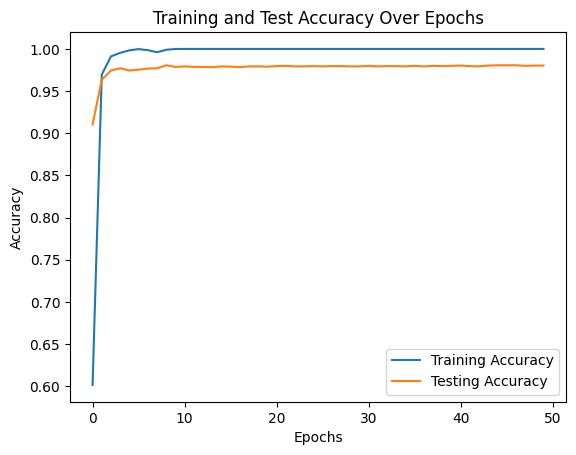

In [13]:
history = model.fit(X_reshaped,Y, epochs=50, batch_size=32, validation_data=(X_test_reshaped, Y_test))
# Visualize the training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()

---


## Visualization

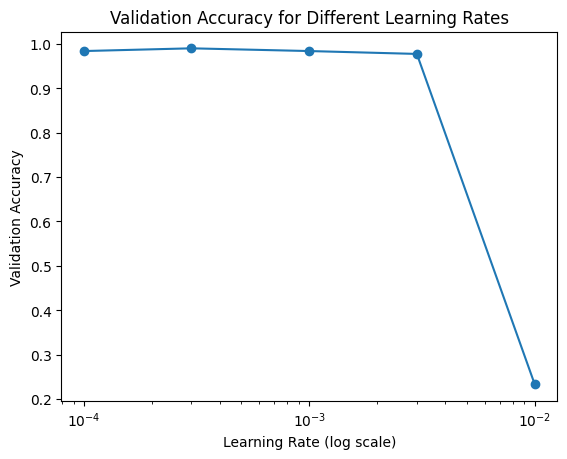

In [ ]:
# Assuming you have your data and labels prepared (X_train, Y_train)

# Learning rates to try
learning_rates = [0.0001, 0.0003, 0.001, 0.003, 0.01]

# Lists to store results
accuracy_results = []

for lr in learning_rates:
    # Build the model
    model = Sequential([
        Conv2D(128, (4, 4), activation='relu', input_shape=(48, 48, 1)),
        MaxPooling2D(2, 2),
        Conv2D(96, (5, 5), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(32, (4, 4), activation='tanh'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
    ])

    # Compile the model with the current learning rate
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_reshaped, Y, epochs=50, validation_data=(X_test_reshaped, Y_test), verbose=0)

    # Store the accuracy from the final epoch
    accuracy_results.append(history.history['val_accuracy'][-1])

# Plot the results
plt.plot(learning_rates, accuracy_results, marker='o')
plt.xscale('log')  # Use a log scale for better visualization
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Different Learning Rates')
plt.show()


A lower learning rate promotes stable convergence as lower the learning rate slower is the training. However, excessively low rates may slow convergence, necessitating a delicate balance in setting this hyperparameter.

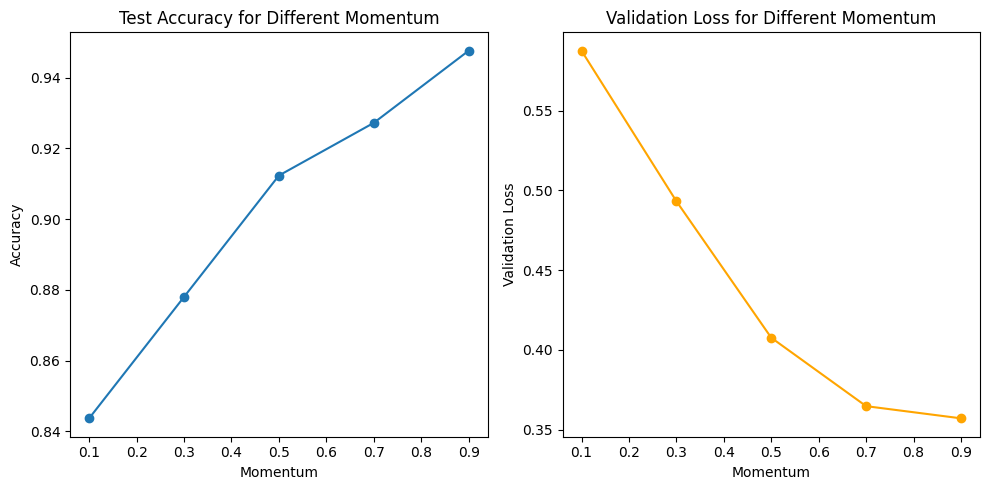

In [14]:
momentum_rates = [0.1, 0.3, 0.5, 0.7, 0.9]

# Lists to store results
accuracy_results = []
validation_loss_results = []

for mr in momentum_rates:
    # Build the model
    model = Sequential([
        Conv2D(128, (4, 4), activation='relu', input_shape=(48, 48, 1)),
        MaxPooling2D(2, 2),
        Conv2D(96, (5, 5), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(32, (4, 4), activation='tanh'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
    ])

    # Compile the model with the current learning rate
    optimizer = SGD(0.001, momentum=mr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_reshaped, Y, epochs=50, validation_data=(X_test_reshaped, Y_test), verbose=0)

    # Store the accuracy and validation loss from the final epoch
    accuracy_results.append(history.history['val_accuracy'][-1])
    validation_loss_results.append(history.history['val_loss'][-1])

# Plot the results
plt.figure(figsize=(10, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(momentum_rates, accuracy_results, marker='o')
plt.xlabel('Momentum')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Different Momentum')

# Plot Validation Loss
plt.subplot(1, 2, 2)
plt.plot(momentum_rates, validation_loss_results, marker='o', color='orange')
plt.xlabel('Momentum')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for Different Momentum')

plt.tight_layout()
plt.show()


Higher momentum in SGD, accelerates convergence by smoothing optimization trajectories, overcoming local minima, reducing noise, and effectively increasing the learning rate, leading to improved accuracy.

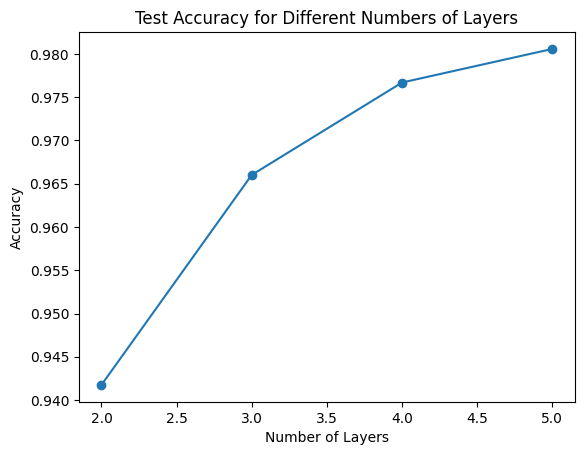

In [21]:
# Number of layers to try
num_layers_list = [2, 3, 4, 5]

# Lists to store results
accuracy_results = []

for num_layers in num_layers_list:
    # Build the model with the current number of layers
    model_layers = [
        Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
        MaxPooling2D(2, 2)
    ]

    for _ in range(num_layers - 1):
        model_layers.extend([
            Conv2D(96, (5, 5), activation='relu', padding='same'),
            MaxPooling2D(2, 2)
        ])

    model_layers.extend([
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
    ])

    model = Sequential(model_layers)

    # Compile the model with the current learning rate
    optimizer = Adam(learning_rate=0.003)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_reshaped, Y, epochs=50, validation_data=(X_test_reshaped, Y_test), verbose=0)

    # Store the accuracy from the final epoch
    accuracy_results.append(history.history['val_accuracy'][-1])

# Plot the results
plt.plot(num_layers_list, accuracy_results, marker='o')
plt.xlabel('Number of Layers')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Different Numbers of Layers')
plt.show()


Increasing the number of layers in a neural network enhances its ability to learn intricate patterns and representations, allowing for better abstraction, generalization, and non-linear transformations, which collectively contribute to improved accuracy on various tasks.

Epoch 1/50
303/303 [==============================] - 5s 8ms/step - loss: 0.8564 - accuracy: 0.6932 - val_loss: 0.2744 - val_accuracy: 0.9126
Epoch 2/50
303/303 [==============================] - 2s 6ms/step - loss: 0.1311 - accuracy: 0.9611 - val_loss: 0.3275 - val_accuracy: 0.8867
Epoch 3/50
303/303 [==============================] - 2s 7ms/step - loss: 0.0716 - accuracy: 0.9799 - val_loss: 0.1886 - val_accuracy: 0.9405
Epoch 4/50
303/303 [==============================] - 2s 6ms/step - loss: 0.0467 - accuracy: 0.9878 - val_loss: 0.2024 - val_accuracy: 0.9424
Epoch 5/50
303/303 [==============================] - 2s 8ms/step - loss: 0.0415 - accuracy: 0.9881 - val_loss: 0.3631 - val_accuracy: 0.9379
Epoch 6/50
303/303 [==============================] - 2s 8ms/step - loss: 0.0267 - accuracy: 0.9926 - val_loss: 0.1756 - val_accuracy: 0.9550
Epoch 7/50
303/303 [==============================] - 3s 9ms/step - loss: 0.0115 - accuracy: 0.9970 - val_loss: 0.2560 - val_accuracy: 0.9460
Epoch 

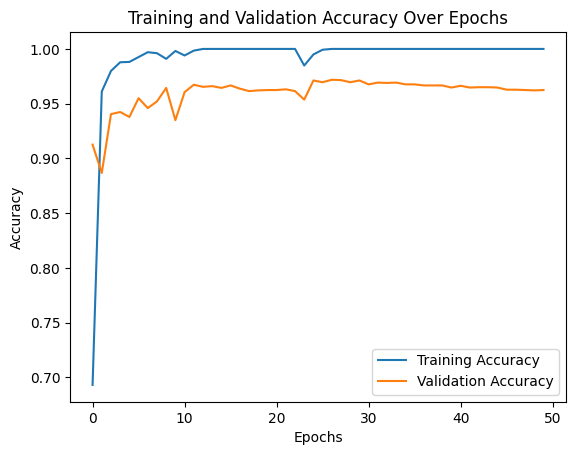

In [22]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Assuming you have defined X_reshaped, Y, X_test_reshaped, and Y_test

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and store the training history
history = model.fit(X_reshaped, Y, epochs=50, batch_size=32, validation_data=(X_test_reshaped, Y_test))

# Visualize the training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

Initially, increasing epochs allows the model to learn more complex patterns and improve accuracy. However, as training progresses, the model may start overfitting to the training data, leading to diminishing returns, where additional epochs contribute less to accuracy improvement, and the rate stabilizes.

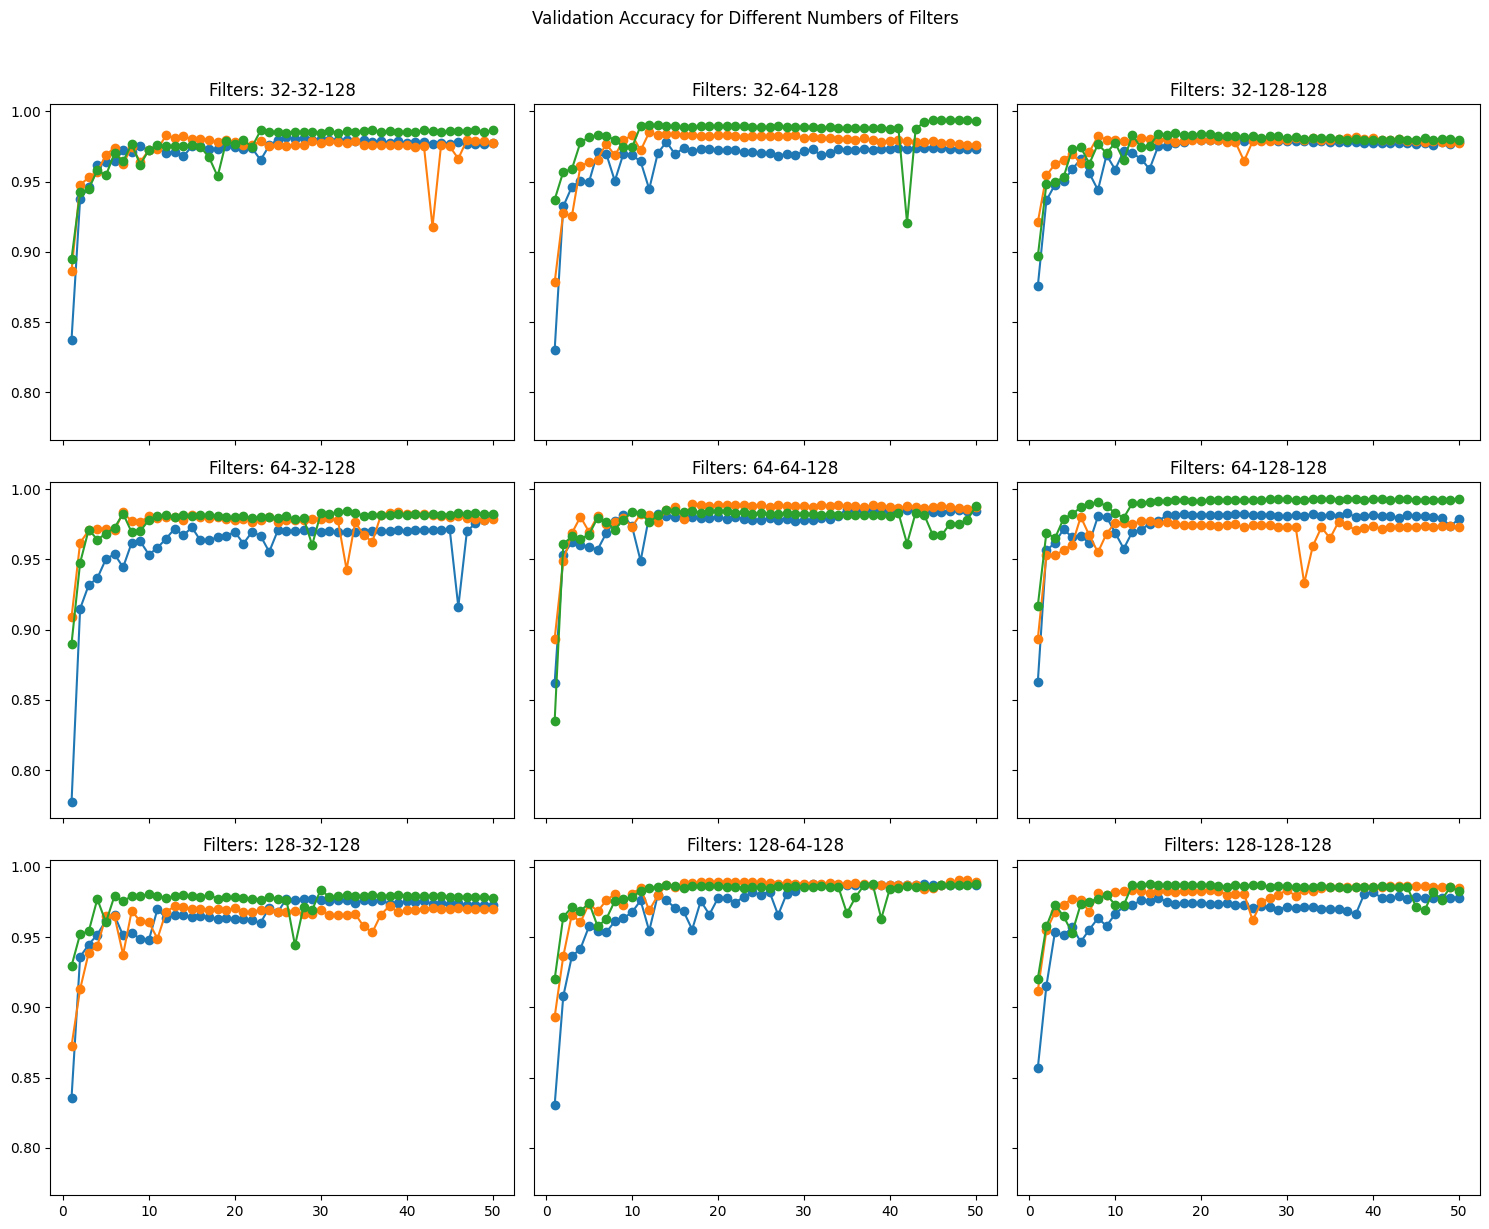

In [26]:
num_filters_list_layer1 = [32, 64, 128]
num_filters_list_layer2 = [32, 64, 128]
num_filters_list_layer3 = [32, 64, 128]

# Dictionary to store accuracy for each configuration
accuracy_results = {}

for num_filters_layer1 in num_filters_list_layer1:
    for num_filters_layer2 in num_filters_list_layer2:
        for num_filters_layer3 in num_filters_list_layer3:
            # Build the model with the current number of filters
            model = tf.keras.models.Sequential([
                tf.keras.layers.Conv2D(num_filters_layer1, (3, 3), activation='relu', input_shape=(48, 48, 1)),
                tf.keras.layers.MaxPooling2D(2, 2),
                tf.keras.layers.Conv2D(num_filters_layer2, (3, 3), activation='relu'),
                tf.keras.layers.MaxPooling2D(2, 2),
                tf.keras.layers.Conv2D(num_filters_layer3, (3, 3), activation='relu'),
                tf.keras.layers.MaxPooling2D(2, 2),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dense(10, activation='softmax')
            ])

            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

            # Train the model and store the training history
            history = model.fit(X_reshaped, Y, epochs=50, batch_size=32, validation_data=(X_test_reshaped, Y_test), verbose=0)

            # Store the accuracy for the current configuration
            accuracy_results[(num_filters_layer1, num_filters_layer2, num_filters_layer3)] = history.history['val_accuracy']

# Visualize the results
fig, axs = plt.subplots(len(num_filters_list_layer1), len(num_filters_list_layer2), figsize=(15, 12), sharex=True, sharey=True)

for i, num_filters_layer1 in enumerate(num_filters_list_layer1):
    for j, num_filters_layer2 in enumerate(num_filters_list_layer2):
        for k, num_filters_layer3 in enumerate(num_filters_list_layer3):
            accuracy_values = accuracy_results[(num_filters_layer1, num_filters_layer2, num_filters_layer3)]
            axs[i, j].plot(range(1, 51), accuracy_values, label=f'Filters: {num_filters_layer1}-{num_filters_layer2}-{num_filters_layer3}', marker='o')
            axs[i, j].set_title(f'Filters: {num_filters_layer1}-{num_filters_layer2}-{num_filters_layer3}')

fig.suptitle('Validation Accuracy for Different Numbers of Filters', y=1.02)
fig.tight_layout()
plt.show()

The hierarchical architecture with 32, 64, and 128 filters in successive layers enables the neural network to progressively capture simple, mid-level, and high-level features, fostering the learning of hierarchical representations for improved performance in classification tasks.